In [1]:
import re
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import unicodecsv as csv
import seaborn as sns
from cycler import cycler
from textwrap import wrap
from IPython.display import display, HTML, Markdown

# Analysize variables.

In [2]:
# Read documentation.
columns_file = r"../records_documentation.txt"

with open(columns_file,"r") as f:
    columns = f.readlines()
columns
        

['[Column 0] ID\n',
 '[Column 1] Birth year: deduced from education history, where available\n',
 '[Column 2] Gender flag: 1=female, 2=male, 0=unknown\n',
 '[Column 3] Skillset1: primary skillset deduced from self-reported skills\n',
 '[Column 4] Skillset1 weight: the extent to which primary skillset is representative of overall self-reported skills\n',
 '[Column 5] Skillset2: secondary skillset deduced from self-reported skills\n',
 '[Column 6] Skillset2 weight: the extent to which secondary skillset is representative of overall self-reported skills\n',
 '[Column 7] City of profile (does not change): where unavailable, the field is left blank\n',
 '[Column 8] Country of Profile (does not change)\n',
 '[Column 9] Education (highest degree attained): 0=none/unknown; 1=high school; 2=vocational degree; 3=associateÕs; 4=bachelorÕs; 5=masterÕs other than MBA; 6=MBA; 7=doctorate (PhD/JD/MD) [NB: Romanian names not covered]\n',
 "[Column 10] Elite institution: a flag indicating whether any o

So:
- Unique identifier: ID.
- Variable Groups:
    - Column 0-10, profile info; 
    - Column 11-28, employment or education info; (c26 = False or True)
        - Column 11-18, general info;
        - Column 19-25, company info;
        - Column 27-28, school info.

In [3]:
# Get unique values for each variable.
empl_file = r"../deloitte_pwc.csv"

unique_values = []
for i in range(33):
    unique_values.append(set())
with open(empl_file,"rb") as f:
    reader = csv.reader(f,encoding='utf-8',escapechar='',delimiter='\t')
    for idx, line in enumerate(reader):
        for i in range(33):
            unique_values[i].add(line[i])
for idx, values in enumerate(unique_values):
    print("[Column {}] ".format(idx)+str(len(values)))
        

[Column 0] 1095185
[Column 1] 84
[Column 2] 3
[Column 3] 45
[Column 4] 390501
[Column 5] 45
[Column 6] 390503
[Column 7] 16127
[Column 8] 258
[Column 9] 8
[Column 10] 2
[Column 11] 849
[Column 12] 3
[Column 13] 763
[Column 14] 3
[Column 15] 2
[Column 16] 3246
[Column 17] 2640332
[Column 18] 865
[Column 19] 1767657
[Column 20] 1557541
[Column 21] 10261
[Column 22] 309
[Column 23] 2
[Column 24] 204454
[Column 25] 739
[Column 26] 2
[Column 27] 8
[Column 28] 2
[Column 29] 1469
[Column 30] 68
[Column 31] 7835
[Column 32] 1003970


In [4]:
# One block to convert data to pd.DataFrame.
empl_file = r"../deloitte_pwc.csv"

entries_lst = []
with open(empl_file,"rb") as f:
    reader = csv.reader(f,encoding='utf-8',escapechar='',delimiter='\t')
    for idx, line in enumerate(reader):
        if idx == 5: # Control number of rows.
            break
        entries_lst.append(line)

samples_lst = entries_lst
entries_df = pd.DataFrame(data=entries_lst)
entries_df#.loc[lambda df:df[26]=='True',[17]]


0     1  2                        3   \
0  ed3c50a8-d2d3-3809-9d2a-0f53574560aa  1980  2  Accounting and Auditing   
1  ed3c50a8-d2d3-3809-9d2a-0f53574560aa  1980  2  Accounting and Auditing   
2  ed3c50a8-d2d3-3809-9d2a-0f53574560aa  1980  2  Accounting and Auditing   
3  ed3c50a8-d2d3-3809-9d2a-0f53574560aa  1980  2  Accounting and Auditing   
4  ed3c50a8-d2d3-3809-9d2a-0f53574560aa  1980  2  Accounting and Auditing   

                   4                      5                    6      7   \
0  0.9292892909340925  Industrial Management  0.00825650305491638  Paris   
1  0.9292892909340925  Industrial Management  0.00825650305491638  Paris   
2  0.9292892909340925  Industrial Management  0.00825650305491638  Paris   
3  0.9292892909340925  Industrial Management  0.00825650305491638  Paris   
4  0.9292892909340925  Industrial Management  0.00825650305491638  Paris   

       8  9   ...     23                  24  25     26 27     28 29 30 31  \
0  France  5  ...  False                           True  5  False            
1  France  5  ...  False                           True     False            
2  France  5  ...  False                          False     False            
3  France  5  ...  False                      54  False     False            
4  France  5  ...  False  paris area, france  54  False     False            

              32  
0  1525765406000  
1  1525765406000  
2  1525765406000  
3  1525765406000  
4  1525765406000  

[5 rows x 33 columns]

In [5]:
# Get an example.
entry = samples_lst[2]
for i in range(len(entry)):
    print("[Column {}] ".format(i)+entry[i])

[Column 0] ed3c50a8-d2d3-3809-9d2a-0f53574560aa
[Column 1] 1980
[Column 2] 2
[Column 3] Accounting and Auditing
[Column 4] 0.9292892909340925
[Column 5] Industrial Management
[Column 6] 0.00825650305491638
[Column 7] Paris
[Column 8] France
[Column 9] 5
[Column 10] False
[Column 11] 2004-09-01
[Column 12] True
[Column 13] 2005-06-01
[Column 14] True
[Column 15] False
[Column 16] 273
[Column 17] Financial Controller Assistant,financial controller,assistant
[Column 18] ACCOUNTING
[Column 19] EADS Astrium
[Column 20] EADS Astrium
[Column 21] 
[Column 22] 
[Column 23] False
[Column 24] 
[Column 25] 
[Column 26] False
[Column 27] 
[Column 28] False
[Column 29] 
[Column 30] 
[Column 31] 
[Column 32] 1525765406000


# Aggregate employment changes to the firm-by-date level.

Definition of employment change types: When only employment records are considered, an employment change will be recognized as
- `hiring` if it changed its company to one of the two companies (Deloitte and PwC, hereafter);
- `firing` if it changed its company from one of the two companies to `TIME_OFF` and stayed in `TIME_OFF` for more than 100 days;
- `leaving` if it changed its company from one of the two companies and not recogized as `firing`.

In [6]:
# Define a class to read and process entries.
class entryProcessor:    
    
    def __init__(self, person_id):
        self.person_id = person_id
        self.profile = [None]*7 # "birth_year","gender","skill1","skill2","country","education_level","f_elite"
        self.employment = [None]*7 # "start_date","end_date","ticker","f_current","job_role","department", "nth_posit"
        
    # Three functions to output records.
    # Varlist: Hiring/Leaving/Firing, Ticker, year-month, profile_info: [...], next_industry.
    def enter_record(self):
        return ['hiring',self.employment[2],self.employment[0]
               ]+self.profile+[self.employment[4],self.employment[5]
                              ]+['']+['',''] 
    def leave_record(self,next_industry):
        return ['leaving',self.employment[2],self.employment[1]
               ]+self.profile+[self.employment[4],self.employment[5]
                              ]+[next_industry]+[entryProcessor.time_diff(self.employment[1],self.employment[0]),
                                                 self.employment[6]]
    def fired_record(self):
        return ['firing',self.employment[2],self.employment[1]
               ]+self.profile+[self.employment[4],self.employment[5]
                              ]+['']+[entryProcessor.time_diff(self.employment[1],self.employment[0]),
                                      self.employment[6]]
    
    # When id changes, record a possible leave and then clear contents.
    def reinitialize(self,entry):
        if self.employment[3]=="False":
            record = self.leave_record('')
        else:
            record = None
        self.__init__(entry[0])
        self.profile = [entry[x] for x in [1,2,3,5,8,9,10]]
        if entry[6] is not None:
            self.profile[3] = '' if float(entry[6])<0.1 else entry[5]
        return record
    
    # Main method: read and process.
    def read(self,entry):
        record = []
        # Reinitialize when id changes.
        if self.person_id != entry[0]:
            leave_last = self.reinitialize(entry)
            if leave_last is not None:
                record.append(leave_last)
        # Then deal with the current entry.
        if entry[3] not in ["-1","Accounting and Auditing"] and entry[26] == "False":
            if self.employment[2] != entry[21]:
                if self.employment[2] in ['D','P']:
                    if entry[25] == "TIME_OFF" and int(entry[16]) > 100:
                        record.append(self.fired_record())
                    else:
                        record.append(self.leave_record(entry[25]))
                self.employment = [None]*7
                if entry[21] in ['D','P']:
                    self.employment[0] = entryProcessor.convert_time(entry[11],entry[12])
                    self.employment[1] = entryProcessor.convert_time(entry[13],entry[14])
                    self.employment[2] = entry[21]
                    self.employment[3] = entry[15]
                    self.employment[4] = entry[17]
                    self.employment[5] = entry[18]
                    self.employment[6] = 0
                    record.append(self.enter_record())
            else:
                self.employment[1] = entryProcessor.convert_time(entry[13],entry[14])
                self.employment[3] = entry[15]
                self.employment[6] += 1
        return record
            
    # Unbound methods.
    def convert_time(date,f_valid_month):
        date_regex = re.match(r"(\d{4})-(\d{2})-\d{2}",date)
        if date_regex is None:
            return None
            #raise ValueError('Not a proper date: {}'.format(date))
        else:
            return date_regex.group(1)+('00' if f_valid_month == 'False' else date_regex.group(2))
    
    def time_diff(end_date,start_date):
        if end_date is not None and start_date is not None:
            edt, sdt = int(end_date), int(start_date)
            yr_diff = edt//100-sdt//100
            emth = edt%100
            smth = sdt%100
            if not yr_diff and not (emth and smth):
                return min(6,(emth-smth-1)%12+1)
            else:
                return yr_diff*12+(emth if emth else 6)-(smth if smth else 6)
        else:
            return np.nan
        
    # For print.
    def __str__(self):
        return "[person_id: {}, profile: {}, employment: {}]".format(self.person_id, self.profile, self.employment)
            
#entry = entryProcessor(None)
#for i in range(50):
#    print(i)
#    print(entry.read(samples_lst[i]))
#    print(entry)

In [7]:
# Read, Identify & Aggregate.
empl_file = r"../deloitte_pwc.csv"

## Initialize.
career = entryProcessor(None)

## Iterate.
empl_changes_lst = []
with open(empl_file,"rb") as f:
    reader = csv.reader(f,encoding='utf-8',escapechar='',delimiter='\t')
    for idx, entry in enumerate(itertools.chain(reader,[[None]*33])):
        if idx == np.inf: # End point.
            break
        empl_change_this = career.read(entry)
        if empl_change_this != []:
            empl_changes_lst += empl_change_this

varlist = [
    "type","ticker","yrmth","birth","gender","skill1","skill2","cntry","edu","f_elite",
    "job_role","depmt","ind_next","tenure","nprom"
]
empl_changes_df = pd.DataFrame(data=empl_changes_lst,columns=varlist)
empl_changes_df


type ticker   yrmth birth gender                        skill1  \
0        hiring      P  200109  1975      2                         Legal   
1        firing      P  200207  1975      2                         Legal   
2        hiring      P  199602  1973      2           Banking and Finance   
3       leaving      P  200202  1973      2           Banking and Finance   
4        hiring      P  201108  1983      1             Middle Management   
5       leaving      P  201304  1983      1             Middle Management   
6        hiring      P  201201  1972      0      CRM and Sales Management   
7       leaving      P  201208  1972      0      CRM and Sales Management   
8        hiring      D  200106  1976      1                    Recruiting   
9       leaving      D  200305  1976      1                    Recruiting   
10       hiring      D  201605  1986      1                Administration   
11       hiring      D  201407  1988      0               Web Development   
12      leaving      D  201512  1988      0               Web Development   
13       hiring      D  201710  1988      0               Web Development   
14       hiring      D  201102  1987      1            Product Management   
15      leaving      D  201302  1987      1            Product Management   
16       hiring      P  201509  1983      0           Banking and Finance   
17      leaving      P  201602  1983      0           Banking and Finance   
18       hiring      D  200705  1976      2  Technical Product Management   
19      leaving      D  201609  1976      2  Technical Product Management   
20       hiring      D  201202  1980      2               Web Development   
21      leaving      D  201411  1980      2               Web Development   
22       hiring      D  201707  1989      1         Industrial Management   
23       hiring      P  201402  1980      0          Business Development   
24      leaving      P  201703  1980      0          Business Development   
25       hiring      D  201009  1981      1      Human Resources (Senior)   
26      leaving      D  201102  1981      1      Human Resources (Senior)   
27       hiring      P  201609  1991      1                Administration   
28       hiring      P  200610  1963      2         Operations Management   
29      leaving      P  201002  1963      2         Operations Management   
...         ...    ...     ...   ...    ...                           ...   
519285   hiring      P  201412  1993      0          Business Development   
519286  leaving      P  201503  1993      0          Business Development   
519287   hiring      D  200907  1978      2         Industrial Management   
519288  leaving      D  201007  1978      2         Industrial Management   
519289   hiring      P  200500  1977      2          Business Development   
519290  leaving      P  200700  1977      2          Business Development   
519291   hiring      D  200505  1975      1                         Sales   
519292  leaving      D  200701  1975      1                         Sales   
519293   hiring      P  201706  1990      1              Sales Management   
519294   hiring      D  200511  1968      2     IT Management and Support   
519295  leaving      D  200704  1968      2     IT Management and Support   
519296   hiring      D  199903  1975      2                     Logistics   
519297  leaving      D  200611  1975      2                     Logistics   
519298   hiring      D  200609  1978      1                     Education   
519299  leaving      D  200908  1978      1                     Education   
519300   hiring      P  201101  1978      0      Non-Profit and Community   
519301  leaving      P  201211  1978      0      Non-Profit and Community   
519302   hiring      P  201106  1961      2           Banking and Finance   
519303  leaving      P  201606  1961      2           Banking and Finance   
519304   hiring      P  201307  1993      2                Administration   
519305 

# Summarize and plot.

**For all other employees other than accountants in Deloitte and PwC.**

In [8]:
# Styles for the four groups: ('ticker': 'D','P') x ('firing', 'hiring')
line_styles = ['bo-','b^--','b^-','ro-','r^--','r^-']
color_styles = ['skyblue','b','dodgerblue','mistyrose','r','salmon']

# Styles for the two tickers: ('D', 'P')
color_styles_2 = ['b','r']

In [9]:
# Deal with 'yrmth'.
empl_changes_df = empl_changes_df.assign(
    year = lambda df:df.yrmth.apply(lambda x:int(x[:4]) if x is not None else np.nan),
    month = lambda df:df.yrmth.apply(lambda x:int(x[4:]) if x is not None else -1)
)

empl_changes_df.describe(include=[np.object])

type  ticker   yrmth   birth  gender                skill1  skill2  \
count   519315  519315  507231  519315  519315                519315  519315   
unique       3       2     697      84       3                    43      45   
top     hiring       D  201509    2000       2  Business Development           
freq    303392  277578    5806   55729  231811                 73998  103941   

                cntry     edu f_elite               job_role   depmt ind_next  \
count          519315  519315  519315                 519315  519315   519315   
unique            235       8       2                  99153     328      536   
top     United States       4   False  Consultant,consultant                    
freq           126330  223436  476338                  23658  329708   391912   

        tenure   nprom  
count   512080  519315  
unique     449      17  
top                     
freq    303392  303392

## Count the number of employees other than accountants rom Dec., 1989 on.

Note: 
- This block counts the number of currently employed accountants for the two firms by calculating the cumulative sums of the net employment increase, that is, hiring minus the sum of firing and leaving.
- This method is not effective for the early years. However, if we can assure that we have all the resumes of accountants after some time, we will have the correct number after all the accountants employed before that time have left the company. We assume that the number is correct after 1989 except the most recent years.
- All the numbers are counted in the end of the year and will be used to calculate the proportion of the employment changes for next year. Note that we do not calculate monthly employment separately since there are a good proportion of our data with invalid months.

In [10]:
count_by_years = pd.DataFrame({'count':empl_changes_df.groupby(['ticker','type','year']).size()}).reset_index()
empl_by_years = count_by_years.groupby(['ticker','type']).apply(
    lambda df:df.sort_values(['year']).assign(cumsum = lambda df2:df2['count'].cumsum()) # Calculate cumsum.
).reset_index(drop=True).pivot_table(
    index=['ticker','year'],columns='type',values=['cumsum'],fill_value=0 # Reshape to wide format.
).assign(
    employment=lambda df:(df['cumsum']['hiring']-df['cumsum']['firing']-df['cumsum']['leaving']) # Get employment.
).drop('cumsum',axis=1).reset_index()
empl_by_years.columns = empl_by_years.columns.droplevel('type')
empl_by_years.pivot_table(
    index='year',columns='ticker',values='employment'
).loc[lambda df:(df.index>=1989)&(df.index<=2016)].plot(
    figsize=(12,6),color=color_styles_2,title="Other Employments by Year (1989-2016)"
)
plt.show()

## Overall trends.
Note: Plots by year and plots by months do not only differ in frequency, but also in sample size. This is due to the entries without valid month record.

In [11]:
# Count and calculate percentages of employment changes.
prop_by_months = pd.DataFrame(
    {'count':empl_changes_df.groupby(['ticker','type','year','month']).size()} # Count by month.
).reset_index().merge(
    right=empl_by_years.assign(year_1L=lambda df:df.year+1)[['ticker','year_1L','employment']],
    left_on = ['ticker','year'], right_on = ['ticker','year_1L'] # Merge with last year's employment.
).assign(
    prop=lambda df:df['count']/df['employment']*100 # Calculate proportions.
).drop(
    ['count','year_1L','employment'],axis=1 # Drop unnecessary variables.
).loc[lambda df:(df.year>=1990)&(df.year<=2016)] # Keep only [1990, 2016] segment.

# Plot by year.
prop_by_months.pivot_table(
    index = ['ticker','year'], columns = 'type', values = 'prop'
).reset_index().assign(
    **{"leaving+firing":lambda df:(df.leaving+df.firing)}
).pivot_table(
    index='year', columns='ticker', values=['hiring','leaving','leaving+firing']
).reorder_levels(
    ['ticker','type'],axis=1
).sort_index(axis=1).plot(
    style=line_styles, figsize=(16,9), title="Percentage Changes of Other Employees by Year (1990-2016)"
).set_ylabel('Percentage')
plt.show()

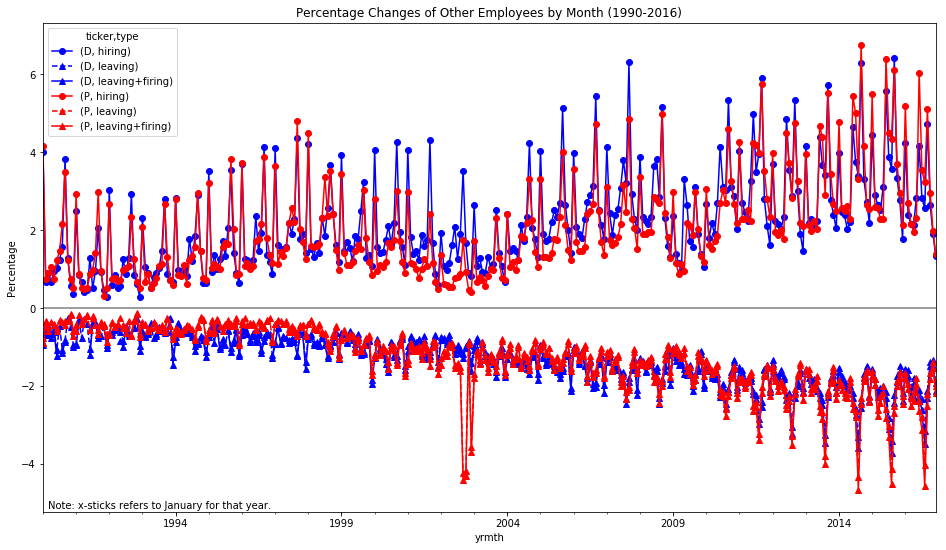

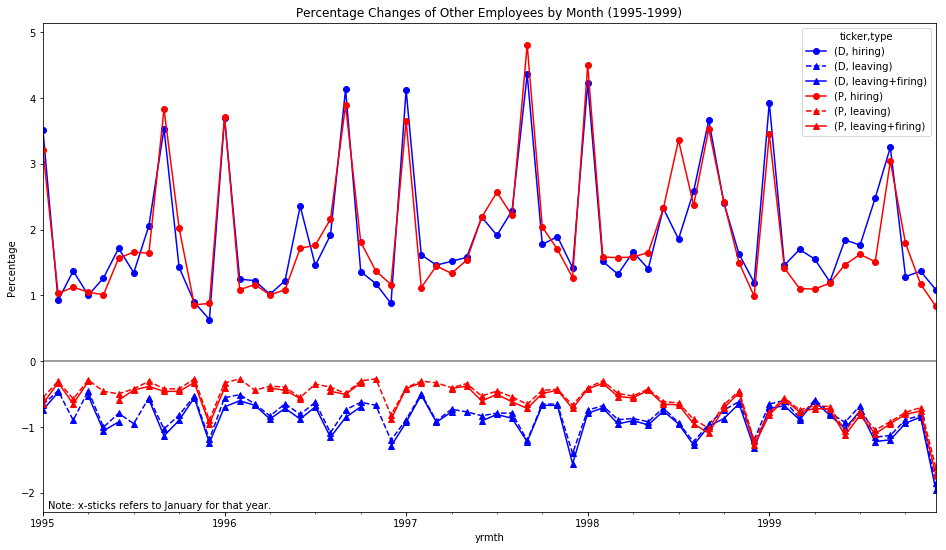

In [12]:
# Plot by month.
## Define a routine for plotting over segments.
def plot_by_month(start_year=1990,end_year=2016):
    prop_by_months.loc[lambda df:(df.month!=0)&(df.year>=start_year)&(df.year<=end_year)].pivot_table(
        index = ['ticker','year','month'], columns='type', values = 'prop'
    ).reset_index().assign(
        **{
            "leaving+firing":lambda df:-(df.leaving+df.firing),
            "leaving":lambda df:-df.leaving,
            "yrmth":lambda df:pd.PeriodIndex(year=df.year,month=df.month,freq='M')
        }
    ).pivot_table(
        index='yrmth', columns='ticker', values=['hiring','leaving','leaving+firing']
    ).reorder_levels(
        ['ticker','type'],axis=1
    ).sort_index(axis=1).plot(
        style=line_styles, figsize=(16,9), 
        title="Percentage Changes of Other Employees by Month ({}-{})".format(start_year,end_year)
    ).set_ylabel('Percentage')
    plt.hlines(0,pd.Period('{}-01'.format(start_year)),pd.Period('{}-12'.format(end_year)),colors='tab:gray')
    plt.annotate("Note: x-sticks refers to January for that year.",(5,3),xycoords="axes points")
    plt.show()

    
plot_by_month() # Plot by month over the whole timespan.
plot_by_month(1995,1999) # An example for plotting by month over 1995-1999.

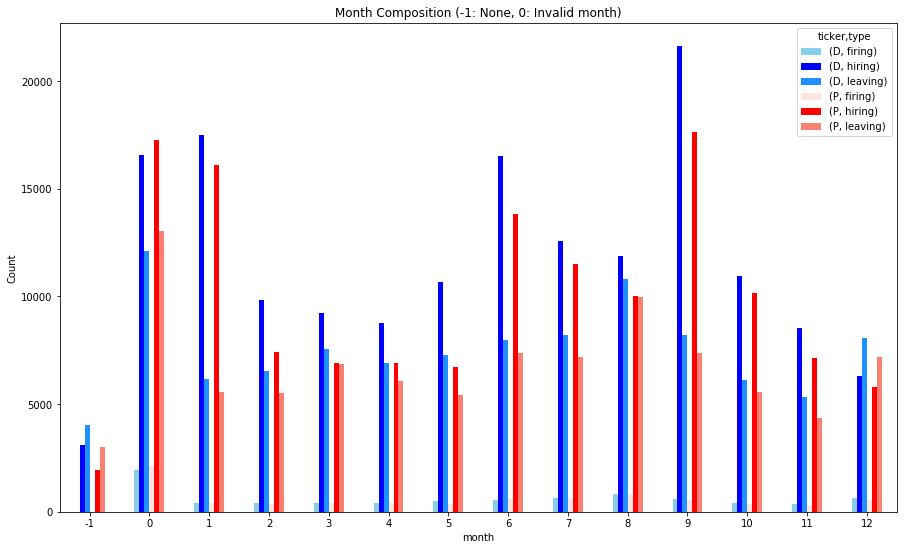

In [13]:
# Month composition.
empl_changes_df.assign(count=1).pivot_table(
    index = 'month', columns = ['ticker','type'], values='count', aggfunc='sum', fill_value=0
).plot.bar(
    figsize=(15,9),color=color_styles,rot=0,
    title="Month Composition (-1: None, 0: Invalid month)"
).set_ylabel("Count")
plt.show()

## By birth group.
Note: Birth year `2000` seems to be a trash bin for problematic records and thus will be treated the same as `None`.

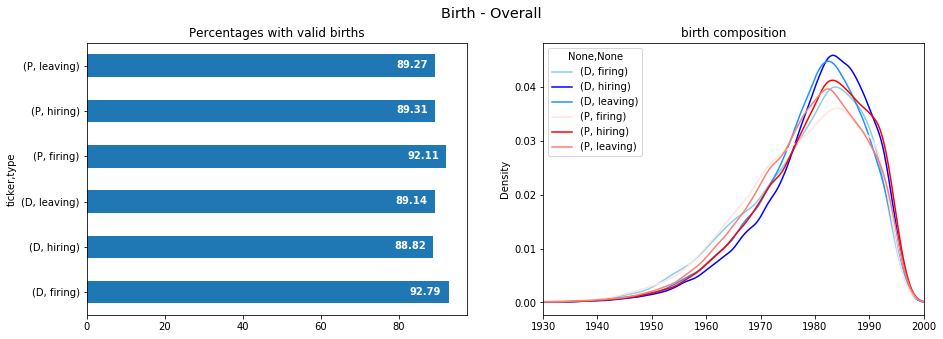

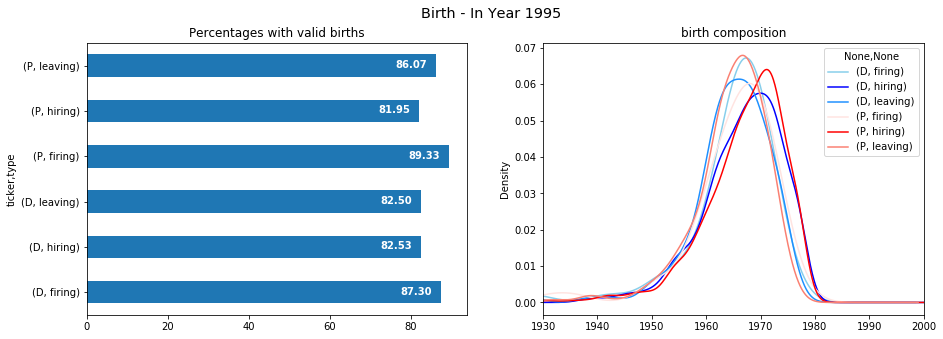

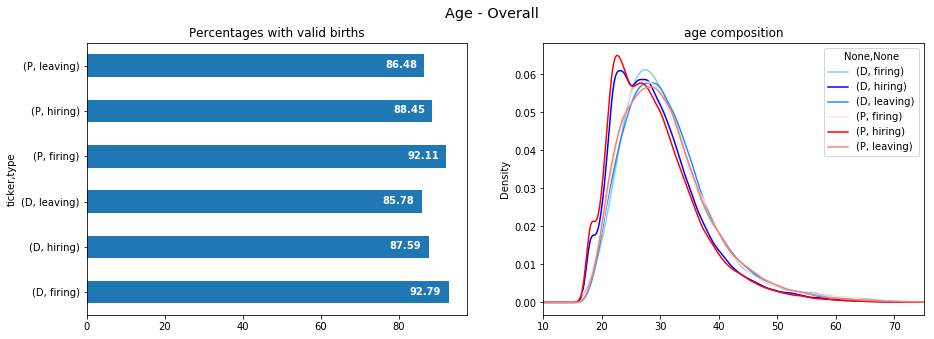

In [14]:
birth_df = empl_changes_df[['ticker','type','year','birth']]
birth_df = birth_df.assign(
    birth = lambda df:df.birth.apply(lambda x:int(x) if x not in ['2000','None'] else np.nan),
    age = lambda df:(df.year-df.birth)
)

# Define a routine to generate plots.
def birth_plot(DF,var,title,xlim=None):
    plt.subplots(1,2,figsize=(15,5))
    plt.suptitle(title,fontsize="x-large")
    plt.subplot(121)
    to_plot = DF.groupby(['ticker','type']).apply(lambda df:(df.loc[~df[var].isnull()].size/df.size*100))
    ax = to_plot.plot.barh(title="Percentages with valid births")
    for idx, value in enumerate(to_plot):
        ax.text(value-10,idx-0.05,'{:.2f}'.format(value),color='white',fontweight='bold')
    plt.subplot(122)
    for (idx, group), color in zip(DF.loc[~DF[var].isnull()].groupby(['ticker','type']),color_styles):
        group[var].plot.kde(xlim=xlim,label=idx,title="{} composition".format(var),color=color,legend=True)
    plt.show()
    
birth_plot(birth_df,'birth',"Birth - Overall",(1930,2000))
birth_plot(birth_df.loc[birth_df.year==1995],'birth',"Birth - In Year 1995",(1930,2000))
birth_plot(birth_df,'age',"Age - Overall",(10,75))
birth_plot(birth_df.loc[birth_df.year==1995],'age',"Age - In Year 1995",(10,75))

In [15]:
# Age changes by year.
fig, ((ax11, ax12), (ax21, ax22))=plt.subplots(2,2,figsize=(15,10))
fig.suptitle('Age Changes by Year (1990-2016)',fontsize='x-large',y=0.95)
birth_df.pivot_table(
    index='year',columns=['ticker','type'],values='age',aggfunc='median'
).plot(xlim=(1990,2016),ylim=(17,47),color=color_styles,ax=ax11,title='median')
birth_df.pivot_table(
    index='year',columns=['ticker','type'],values='age',aggfunc='mean'
).plot(xlim=(1990,2016),ylim=(17,47),color=color_styles,ax=ax12,title='mean')
birth_df.loc[empl_changes_df.gender=='1'].pivot_table(
    index='year',columns=['ticker','type'],values='age',aggfunc='mean'
).plot(xlim=(1990,2016),ylim=(17,47),color=color_styles,ax=ax21,title='mean - female')
birth_df.loc[empl_changes_df.gender=='2'].pivot_table(
    index='year',columns=['ticker','type'],values='age',aggfunc='mean'
).plot(xlim=(1990,2016),ylim=(17,47),color=color_styles,ax=ax22,title='mean - male')
plt.show()

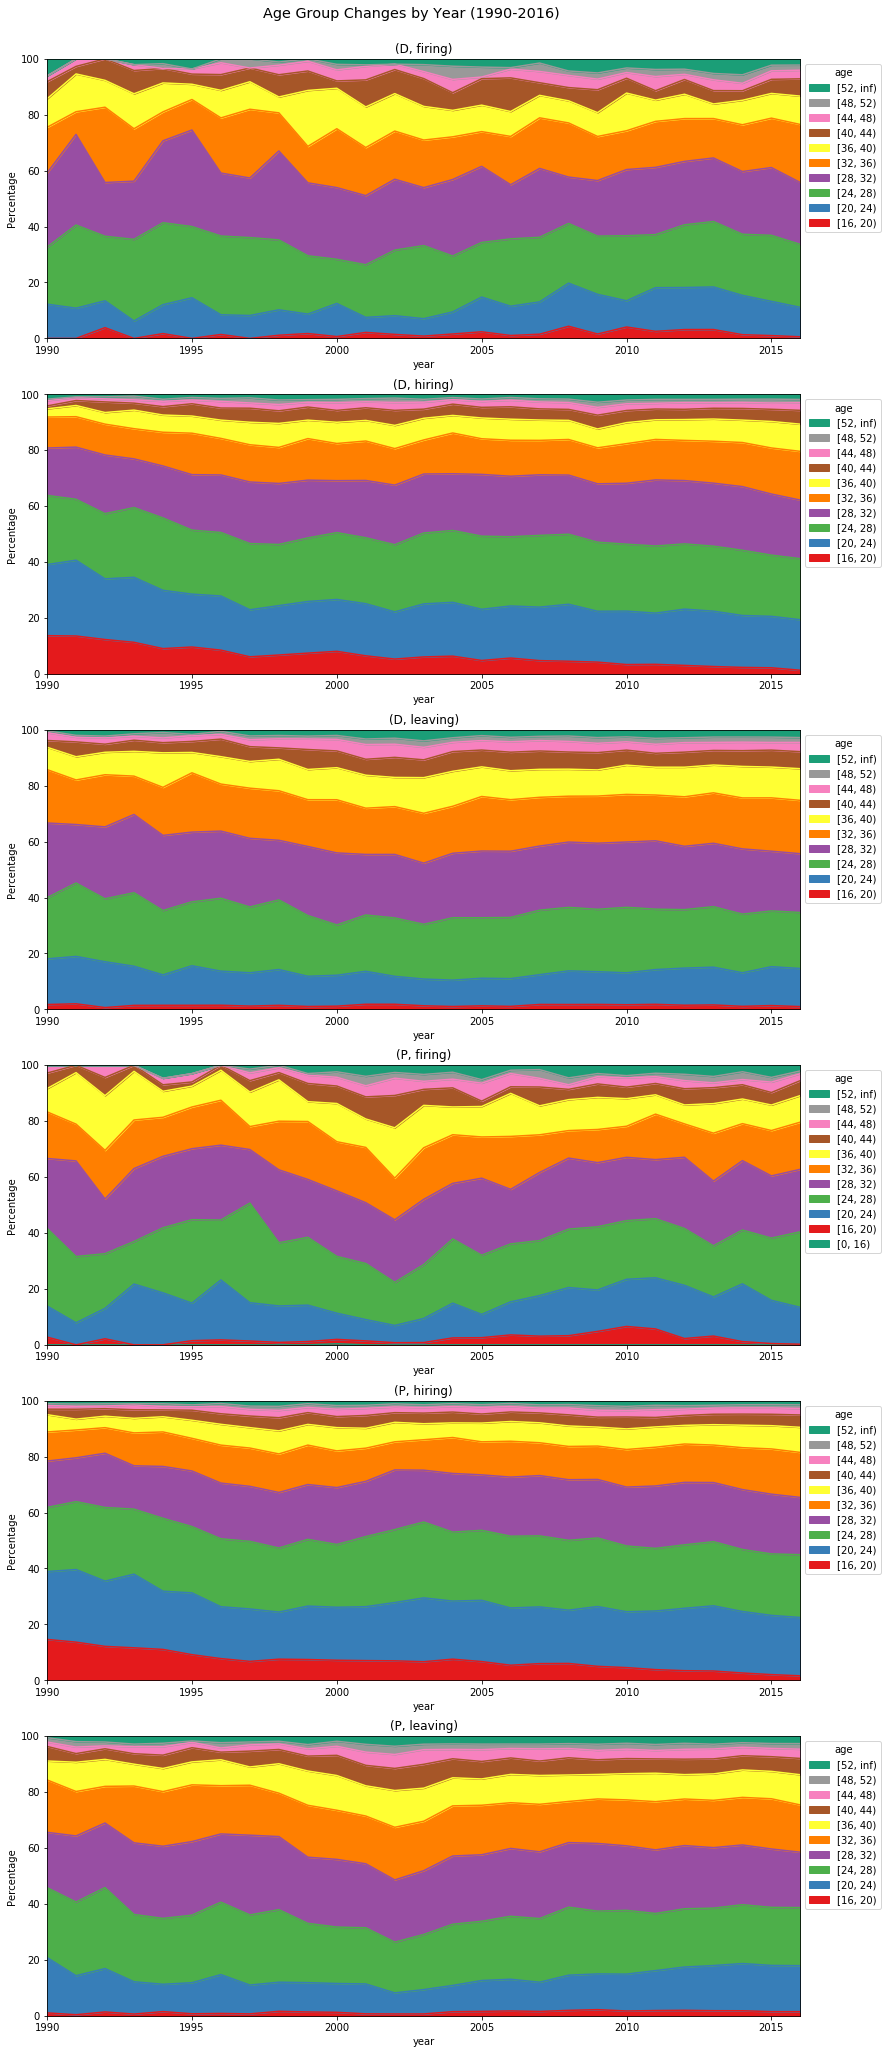

In [16]:
# Age group changes by year.
f_none_hidden = False # Whether to hide the ones out of [16, 52)
bins = list(np.arange(16,55,4))
colormap_unif = list(plt.get_cmap('Set1').colors+plt.get_cmap('Set2').colors+plt.get_cmap('Set3').colors)[:len(bins)-1]
if not f_none_hidden:
    bins = [0]+bins+[np.inf]
    colormap_unif = [plt.get_cmap('Dark2').colors[0]]+colormap_unif+[plt.get_cmap('Dark2').colors[0]]

# Plot composition changes by years.
fig, axs = plt.subplots(6,1,figsize=(13.5,36))
fig.suptitle("Age Group Changes by Year (1990-2016)", fontsize='x-large', y=0.9)
for (idx, grp), ax in zip(
    birth_df.loc[
        lambda df:(df.year>=1990)&(df.year<=2016), ['ticker','type','year','age']
    ].groupby(['ticker','type']), axs
):
    to_plot = grp.assign(count=1).pivot_table(
        index='year', columns=pd.cut(grp.age, bins, right=False, labels=False), values='count', aggfunc='sum', fill_value=0
    ).apply(lambda x:x/sum(x)*100, axis=1)
    to_plot.plot(
        kind='area', ax=ax, ylim=(0,100), title=str(idx).replace("'",""),
        color=[colormap_unif[int(float(i))] for i in to_plot.columns]
    )
    ax.set_ylabel("Percentage")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        reversed(handles), ["[{}, {})".format(bins[int(float(x))], bins[int(float(x))+1]) for x in reversed(labels)], 
        loc='upper left',bbox_to_anchor=(1,1),title='age'
    )
plt.show()

## By Gender.

In [17]:
fig, (ax1, ax2)=plt.subplots(1,2,figsize=(15,5))
empl_changes_df.pivot_table(
    index='year',columns=['ticker','type'],values='gender',
    aggfunc=lambda x:((x=='1').sum()/(x=='2').sum() if (x=='2').sum() else np.nan)
).plot(xlim=(1990,2016),color=color_styles,title="Female-to-Male Ratio Changes",ax=ax1)
empl_changes_df.pivot_table(
    index='year',columns=['ticker','type'],values='gender',
    aggfunc=lambda x:((x!='0').sum()/x.size)
).plot(xlim=(1990,2016),color=color_styles,title="Gender Availability Changes",ax=ax2)
plt.show()

In [18]:
# Age group changes by year.
f_none_hidden = False # Whether to hide the ones out of [16, 52)
bins = list(np.arange(16,55,4))
colormap_unif = list(plt.get_cmap('Set1').colors+plt.get_cmap('Set2').colors+plt.get_cmap('Set3').colors)[:len(bins)-1]
if not f_none_hidden:
    bins = [0]+bins+[np.inf]
    colormap_unif = [plt.get_cmap('Dark2').colors[0]]+colormap_unif+[plt.get_cmap('Dark2').colors[0]]

# Plot composition changes by years.
fig, axs = plt.subplots(6,1,figsize=(13.5,36))
fig.suptitle("Age-Gender Group Changes by Year (1990-2016)", fontsize='x-large', y=0.90)
fig.text(0.25,0.89,
         "Only for those with gender info available. The lighter color for female, and the deeper color for male.")
for (idx, grp), ax in zip(
    birth_df.loc[
        lambda df:(df.year>=1990)&(df.year<=2016)&(empl_changes_df.gender!='0'), ['ticker','type','year','age']
    ].groupby(['ticker','type']), axs
):
    to_plot = grp.assign(count=1).pivot_table(
        index='year', columns=[pd.cut(grp.age, bins, right=False, labels=False), empl_changes_df.gender], 
        values='count', aggfunc='sum', fill_value=0
    ).apply(lambda x:x/sum(x)*100, axis=1)
    to_plot.plot(
        kind='area', ax=ax, ylim=(0,100), title=str(idx).replace("'",""),
        color=[
            colormap_unif[int(float(i))] if j=='1' else tuple(t/1.1 for t in colormap_unif[int(float(i))]) 
            for i,j in to_plot.columns
        ]
    )
    ax.set_ylabel("Percentage")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        reversed([handles[i] for i in range(len(handles)) if i%2==0]), 
        reversed(["[{}, {})".format(bins[int(float(x))], bins[int(float(x))+1]) for x in
            [re.match(r"\((\d+)\.0",labels[i]).group(1) for i in range(len(labels)) if i%2==0]
        ]), 
        loc='upper left',bbox_to_anchor=(1,1)
    )
plt.show()

## By Primary Skill.

In [19]:
# Create a uniform colormap for all subplots.
skill1_ord_unif = empl_changes_df.groupby('skill1').size().sort_values(ascending=False).index.tolist()
colormap_unif = {idx:clr for idx, clr in zip(
    skill1_ord_unif,
    itertools.cycle(plt.get_cmap('Set1').colors+plt.get_cmap('Set2').colors+plt.get_cmap('Set3').colors)
)}
colormap_unif['Others'] = plt.get_cmap('Dark2').colors[0]

# Codes for showing pie charts:
# fig,axs=plt.subplots(3,2,figsize=(15,22.5))
# fig.suptitle("Secondary Skill Composition",fontsize='x-large')
# for (idx,col),ax in zip(
#     empl_changes_df.loc[:].pivot_table(
#         index='skill1',columns=['ticker','type'],values='gender',aggfunc='count'
#     ).iteritems(), itertools.chain.from_iterable(axs)
# ):
#     to_plot0 = col.sort_values(ascending=False)
#     to_plot = to_plot0.iloc[0:18]
#     to_plot.loc['Others']=to_plot0.sum()-to_plot.sum()  
#     ax=to_plot.plot.pie(
#         ax=ax,labeldistance=1.05,title=str(idx).replace("'",''),autopct='%.2f',pctdistance=0.9,
#         colors = [colormap_unif[idx] for idx in to_plot.index]
#     )
#     ax.set_ylabel('')
# plt.show()

## Continued ##
N_cats = 15 # Number of categories to be shown.

# Plot composition changes by years.
fig, axs = plt.subplots(6,1,figsize=(12.5,36))
fig.suptitle("Primary Skill Composition Change by Year (1990-2016)", fontsize='x-large', y=0.9)
for (idx, grp), ax in zip(
    empl_changes_df.loc[
        lambda df:(df.year>=1990)&(df.year<=2016), ['ticker','type','year','skill1']
    ].groupby(['ticker','type']), axs
):
    to_plot = grp.assign(
        skill1_id = lambda df:[
            {val:(idx if idx<N_cats else N_cats) for idx, val in enumerate(skill1_ord_unif)}[x] for x in df.skill1
        ], count = 1
    ).pivot_table(
        index='year', columns='skill1_id', values='count', aggfunc='sum', fill_value=0 
    ).apply(lambda x:x/sum(x)*100, axis=1)
    to_plot.columns = skill1_ord_unif[:N_cats]+["Others"]
    to_plot.plot(
        kind='area', ax=ax, color=[colormap_unif[idx] for idx in to_plot.columns],
        ylim=(0,100), title=str(idx).replace("'","")
    )
    ax.set_ylabel("Percentage")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        reversed(handles), reversed(['\n'.join(wrap(x,30)) for x in labels]), 
        loc='upper left',bbox_to_anchor=(1,1)
    )
plt.show()

In [20]:
edu_lablst = {
    0:"None/Unknown", 1:"High school", 2:"Vocational degree", 3:"Associates", 
    4:"Bachelors", 5:"Masters excl. MBA", 6:"MBA", 7:"Doctorate (PhD/JD/MD)"
}

# Find representative profiles.
for i in range(5):
    display(HTML("<strong>"+skill1_ord_unif[i]+"</strong>"))
    to_plot = empl_changes_df.assign(edu=lambda df:df.edu.apply(lambda x:edu_lablst[int(x)])).loc[
        lambda df:(df.skill1==skill1_ord_unif[i]),
        ["job_role","depmt","edu","f_elite"]
    ]
    N = to_plot.shape[0]
    # Job role.
    varname = "job_role"
    top10_job_role = pd.DataFrame([v
        for w in to_plot.groupby(varname).size().reset_index().apply(
        lambda x:[[y.title(),z] for y in x[varname].split(',') for z in [x[0]/(x[varname].count(',')+1)]]
        ,axis=1) for v in w
    ],columns=[varname,"count"]).groupby(varname).sum().reset_index().sort_values(
        "count",ascending=False
    ).head(10).assign(
        prop=lambda df:(df["count"]/N*100).apply(round,ndigits=2)
    ).reset_index(drop=True).drop("count",axis=1)
    # Department.
    varname = "depmt"
    to_plot_depmt = to_plot.loc[lambda df:df[varname]!='']
    N_depmt = to_plot_depmt.shape[0]
    top10_depmt = pd.DataFrame([v
        for w in to_plot_depmt.groupby(varname).size().reset_index().apply(
        lambda x:[[y.title(),z] for y in x[varname].split(',') for z in [x[0]/(x[varname].count(',')+1)]]
        ,axis=1) for v in w
    ],columns=[varname,"count"]).groupby(varname).sum().reset_index().sort_values(
        "count",ascending=False
    ).head(10).assign(
        prop=lambda df:(df["count"]/N_depmt*100).apply(round,ndigits=2)
    ).reset_index(drop=True).drop("count",axis=1)
    # Education.
    top10_edu = to_plot.groupby("edu").size().sort_values(ascending=False).apply(
        lambda x:round(x/N*100,2)).rename("prop").reset_index()
    # show.
    display(HTML("<em>Top 10 entries for each variables with proportions:</em>"))
    display(pd.concat([top10_job_role,top10_depmt,top10_edu], axis=1))
    # Some examples.
    to_plot = to_plot.sample(30)
    display(HTML("<em>Some examples:</em>"))
    display(to_plot)
    

job_role  prop       depmt   prop                    edu   prop
0             Intern  4.54  Accounting  48.42              Bachelors  39.80
1         Consultant  4.48    Business  11.17      Masters excl. MBA  30.45
2            Auditor  3.31          Hr  10.48           None/Unknown  14.97
3          Associate  2.90   Oversight   8.19                    MBA   9.41
4              Audit  2.49   Marketing   7.43            High school   2.31
5            Analyst  2.06  Technology   5.98  Doctorate (PhD/JD/MD)   1.64
6  Senior Consultant  2.04  Operations   4.36      Vocational degree   1.36
7             Senior  2.00       Legal   2.48             Associates   0.07
8            Manager  1.98  Management   1.18                    NaN    NaN
9            Trainee  1.67  Production   0.26                    NaN    NaN

job_role       depmt  \
32069                      Consultor financiero,consultor               
289481     Innovation Junior Consultant,junior consultant    BUSINESS   
309888                                    Trainee,trainee               
341111                       Stagiaire auditeur,stagiaire               
336353                   "Coop ""Consultant""",consultant               
25517                               Consultant,consultant               
338042                                      Intern,intern               
221149                              Consultant,consultant               
335833                                    Auditora Sênior               
218370                                    Analyst,analyst               
323521                    Legal Assistant,legal assistant       LEGAL   
463167                      Assistant marketing,assistant   MARKETING   
163756      Business Analyst in Strategy,business analyst    BUSINESS   
324396                        Auditeur financier,auditeur               
444353                   Asistente de Auditoria,asistente               
465522                                    Auditor,auditor               
253810                Financial Advisor,financial advisor  ACCOUNTING   
75402   Manager Customer Strategy and Experience,manag...    BUSINESS   
14448                                           Auditoría               
466643          Assistante Marketing,assistante,marketing   MARKETING   
91544                                   Director,director   OVERSIGHT   
168840  Associate | PwC Drone Powered Solutions | Advi...    BUSINESS   
347251                         Auditor financiero,auditor               
193714                        Gerente de Projetos,gerente               
465904                            Team Leader,team leader               
179862                                Associate,associate               
330565  Auditeur Financier Banques/Assurances,auditeur...               
67816     Analista de Marketing Júnior,analista,marketing   MARKETING   
169674                          SAP Consultant,consultant               
48849                                       Intern,intern               

                      edu f_elite  
32069                 MBA   False  
289481  Masters excl. MBA   False  
309888          Bachelors   False  
341111       None/Unknown   False  
336353          Bachelors   False  
25517           Bachelors    True  
338042          Bachelors   False  
221149          Bachelors   False  
335833          Bachelors   False  
218370       None/Unknown   False  
323521          Bachelors   False  
463167  Masters excl. MBA   False  
163756          Bachelors   False  
324396  Masters excl. MBA   False  
444353          Bachelors   False  
465522  Masters excl. MBA   False  
253810  Masters excl. MBA   False  
75402           Bachelors   False  
14448           Bachelors   False  
466643  Masters excl. MBA   False  
91544         High school   False  
168840  Masters excl. MBA    True  
347251  Vocational degree   False  
193714          Bachelors   False  
465904          Bachelors   False  
179862  Masters excl. MBA   False  
330565  Masters excl. MBA   False  
67816           Bachelors   False  
169674  Masters excl. MBA   False  
48849   Masters excl. MBA   False

job_role  prop       depmt   prop                    edu   prop
0            Manager  7.03  Accounting  46.63              Bachelors  38.23
1         Consultant  5.40   Oversight  20.28      Masters excl. MBA  26.58
2          Associate  4.40          Hr  13.33                    MBA  16.22
3   Senior Associate  4.19    Business  12.11           None/Unknown  14.86
4                  "  3.96  Operations   3.21  Doctorate (PhD/JD/MD)   3.03
5  Senior Consultant  3.85  Technology   2.01            High school   0.70
6     Senior Manager  3.60   Marketing   1.47      Vocational degree   0.30
7             Intern  3.48       Legal   0.61             Associates   0.08
8            Auditor  3.21  Production   0.20                    NaN    NaN
9              Audit  2.77  Management   0.15                    NaN    NaN

job_role  \
214512  Audit Manager Financial Services Industry Prac...   
250193                                    Manager,manager   
516217  Financial Auditor Intern in Middle Market Divi...   
74305                                     Analyst,analyst   
154769        Management Consultant,management consultant   
389633       Strategy Consulting Intern,consulting,intern   
237324        International Tax Consultant,tax consultant   
84018                                 Executive,executive   
427866                    Chartered Accountant,accountant   
165858          Intern - Corporate Finance,intern,finance   
18068   Manager - Real Estate Capital Markets Group,re...   
394693  Summer Financial Consulting Analyst,financial,...   
519133                                    Manager,manager   
95865                 Consulting Intern,consulting,intern   
258891              PricewaterhouseCoopers tianjin branch   
318827  Consultant in Financial Services,consultant,fi...   
369047  Senior Consultant - Strategy & Operations Cons...   
50258    Strategy and Operations Intern,operations,intern   
393847                      Senior Auditor,senior auditor   
501831                          Audit Senior,audit,senior   
389915        Senior Manager Prokurist,senior manager,","   
169645                  Senior Associate,senior associate   
424577                                    Analyst,analyst   
75100                                     Manager,manager   
154297                      Senior Analyst,senior analyst   
346505  Senior Manager Financial Services Consulting,s...   
11303                           Audit Intern,audit,intern   
7528                        Owner - Retired,owner,retired   
117215                      Senior Analyst,senior analyst   
466589                                    Manager,manager   

                        depmt                    edu f_elite  
214512          HR,ACCOUNTING              Bachelors   False  
250193                                     Bachelors   False  
516217    ACCOUNTING,BUSINESS      Masters excl. MBA   False  
74305                                   None/Unknown   False  
154769                                     Bachelors   False  
389633               BUSINESS      Masters excl. MBA   False  
237324             ACCOUNTING              Bachelors   False  
84018                                   None/Unknown   False  
427866                                     Bachelors   False  
165858    ACCOUNTING,BUSINESS      Masters excl. MBA   False  
18068   OPERATIONS,ACCOUNTING              Bachelors   False  
394693             ACCOUNTING              Bachelors    True  
519133                         Doctorate (PhD/JD/MD)    True  
95865                                      Bachelors    True  
258891                                     Bachelors   False  
318827          HR,ACCOUNTING  Doctorate (PhD/JD/MD)    True  
369047    OPERATIONS,BUSINESS      Masters excl. MBA   False  
50258     OPERATIONS,BUSINESS      Masters excl. MBA   False  
393847                                           MBA   False  
501831             ACCOUNTING            High school   False  
389915                                  None/Unknown   False  
169645                                     Bachelors   False  
424577                             Masters excl. MBA   False  
75100                                            MBA    True  
154297                                           MBA    True  
346505          HR,ACCOUNTING                    MBA   False  
11303              ACCOUNTING      Masters excl. MBA    True  
7528                OVERSIGHT           None/Unknown   False  
117215                                     Bachelors   False  
466589                                  None/Unknown   False

job_role   prop       depmt   prop                    edu  \
0             Consultant  10.60   Oversight  32.81              Bachelors   
1                Manager  10.14  Technology  20.47           None/Unknown   
2      Senior Consultant   8.84  Accounting  13.50      Masters excl. MBA   
3         Senior Manager   6.69          Hr  10.27                    MBA   
4               Director   3.69    Business   9.44  Doctorate (PhD/JD/MD)   
5                      "   2.79  Operations   7.14            High school   
6  Management Consultant   2.24   Marketing   4.38      Vocational degree   
7                Partner   2.24       Legal   0.78             Associates   
8                 Senior   1.77  Production   0.74                    NaN   
9               Services   1.30  Management   0.38                    NaN   

    prop  
0  34.22  
1  24.76  
2  21.54  
3  15.04  
4   2.64  
5   1.24  
6   0.45  
7   0.11  
8    NaN  
9    NaN

job_role  \
16973                                     Manager,manager   
189967                  Internal Auditor,internal auditor   
345937        Management Consultant,management consultant   
191982  Business Risk Manager Finance & Operations Ris...   
492600                        Application Manager,manager   
475318                  Senior Associate,senior associate   
239098                Assistant Manager,assistant manager   
185239          Manager Consultant,manager,",",consultant   
308804    Consultor de estrategia y operaciones,consultor   
389502                                    Manager,manager   
135312                         Consultor senior,consultor   
504982                  Senior Associate,senior associate   
128960                Senior Consultant,senior consultant   
33195   Senior Translator / Proofreader Assurance,seni...   
320531                 Ex Audit Assistant,audit,assistant   
13404                               Consultant,consultant   
194280              Consulting Analyst,consulting,analyst   
309388                      Senior Manager,senior manager   
463400                              Consultant,consultant   
343356                              Consultant,consultant   
368178  Consultora de Recursos Humanos,recursos humano...   
159797                              Consultant,consultant   
396686                      Senior Manager,senior manager   
57181                 Senior Consultant,senior consultant   
305895                              Consultant,consultant   
342653                               Revisionsmitarbeiter   
454269                   Accounting consultant,accounting   
388795                    Sr Consultant,senior consultant   
494255                                 Projektassistentin   
436593  Senior Manager – Enterprise Architecture,senio...   

                                  depmt                edu f_elite  
16973                                         None/Unknown   False  
189967                                                 MBA   False  
345937                                                 MBA   False  
191982  OPERATIONS,ACCOUNTING,OVERSIGHT                MBA   False  
492600                                        None/Unknown   False  
475318                                           Bachelors   False  
239098                                   Masters excl. MBA   False  
185239                                        None/Unknown   False  
308804                                        None/Unknown   False  
389502                                                 MBA   False  
135312                                           Bachelors   False  
504982                                   Masters excl. MBA   False  
128960                                                 MBA   False  
33195                                    Masters excl. MBA   False  
320531                       ACCOUNTING  Masters excl. MBA   False  
13404                                    Masters excl. MBA   False  
194280                                           Bachelors   False  
309388                                        None/Unknown   False  
463400                                   Masters excl. MBA   False  
343356                                                 MBA   False  
368178                                           Bachelors   False  
159797                                           Bachelors    True  
396686                                                 MBA    True  
57181                                            Bachelors    True  
305895                                                 MBA   False  
342653                                        None/Unknown   False  
454269                       ACCOUNTING        High school   False  
388795                                        None/Unknown   False  
494255                                        None/Unknown   False  
436593                       PRODUCTION          Bachelors   False

job_role   prop       depmt   prop                    edu   prop
0               Intern  12.64  Accounting  53.47              Bachelors  59.48
1            Associate   5.68          Hr  11.00      Masters excl. MBA  20.08
2                Audit   3.34   Oversight  10.26           None/Unknown  12.10
3           Consultant   2.83  Technology   8.37                    MBA   3.16
4                  Tax   2.39    Business   7.28            High school   2.37
5              Analyst   2.30   Marketing   4.24      Vocational degree   1.13
6  Executive Assistant   1.95  Operations   3.51  Doctorate (PhD/JD/MD)   1.06
7     Assurance Intern   1.94       Legal   1.07             Associates   0.63
8        Summer Intern   1.66  Management   0.42                    NaN    NaN
9         Audit Intern   1.35  Production   0.36                    NaN    NaN

job_role  \
155477       Administrative/Marketing Assistant,assistant   
407750          how to succeed at psychometric assessment   
170776                Partner Assistant,partner,assistant   
382494  Consultant - Strategy & Operations,consultant,...   
404043                          Audit Intern,audit,intern   
181110                            Discovery Intern,intern   
305316  Experienced Associate - Financial Markets,asso...   
255915                              Tax Intern,tax,intern   
202124                Consulting Intern,consulting,intern   
472892            Secretary Assistant,secretary,assistant   
191274                  Research Analyst,research analyst   
257870                                  IFS Intern,intern   
284693                    Audit Assistant,audit,assistant   
430049        Assurance Senior Associate,senior associate   
488516                   Multistate Tax Intern,tax,intern   
200271          Associate Consultant,associate consultant   
471498                                      Intern,intern   
297632  Executive - Learning and Development,executive...   
444903                          Audit Intern,audit,intern   
231514                                      Intern,intern   
117473            Intern at Immigration department,intern   
440486                                Associate,associate   
51910      Assurance group admin secretary,administration   
143125            Product/Developer @ Deloitte Blockchain   
37378   Management Consulting Associate,management,con...   
81022      Technology Consulting Intern,consulting,intern   
18528   Global Financial Services Industry Intern,fina...   
251646                     Summer Scholar (Intern),intern   
142725                                      Senior,senior   
53644   Summer Financial Markets Analyst,financial,ana...   

                      depmt                edu f_elite  
155477                            None/Unknown   False  
407750                            None/Unknown   False  
170776            OVERSIGHT       None/Unknown   False  
382494  OPERATIONS,BUSINESS                MBA   False  
404043           ACCOUNTING          Bachelors   False  
181110                               Bachelors   False  
305316           ACCOUNTING          Bachelors   False  
255915           ACCOUNTING  Masters excl. MBA   False  
202124                               Bachelors    True  
472892                            None/Unknown   False  
191274           TECHNOLOGY          Bachelors   False  
257870                               Bachelors   False  
284693           ACCOUNTING          Bachelors   False  
430049                       Masters excl. MBA   False  
488516           ACCOUNTING  Masters excl. MBA    True  
200271                               Bachelors   False  
471498                               Bachelors   False  
297632                               Bachelors   False  
444903           ACCOUNTING          Bachelors   False  
231514                       Masters excl. MBA   False  
117473                               Bachelors   False  
440486                               Bachelors   False  
51910                             None/Unknown   False  
143125                               Bachelors   False  
37378                        Masters excl. MBA   False  
81022            TECHNOLOGY          Bachelors   False  
18528         HR,ACCOUNTING          Bachelors   False  
251646                               Bachelors    True  
142725                       Masters excl. MBA   False  
53644            ACCOUNTING          Bachelors    True

job_role   prop       depmt   prop                    edu   prop
0         Consultant  15.96  Technology  44.61              Bachelors  46.50
1  Senior Consultant  10.86    Business  17.58           None/Unknown  20.01
2            Manager   6.84  Accounting   9.19      Masters excl. MBA  19.62
3            Analyst   3.55   Oversight   9.12                    MBA   9.72
4             Senior   2.51          Hr   6.80  Doctorate (PhD/JD/MD)   2.00
5           Business   2.08  Operations   4.72            High school   1.46
6     Senior Manager   2.07   Marketing   3.68      Vocational degree   0.48
7                  "   1.71  Production   2.47             Associates   0.23
8   Senior Associate   1.55       Legal   1.54                    NaN    NaN
9   Business Analyst   1.54   Tehnology   0.20                    NaN    NaN

job_role               depmt  \
100349          Analista Programador,analista programador                       
381004                  Business Analyst,business analyst                       
409901                                    Manager,manager                       
389602       Business Technology Analyst,business,analyst          TECHNOLOGY   
517069      Intern in Training Department,intern,training                  HR   
180180  Senior Technical Oracle Consultant,senior,tech...                       
58681   Salesforce Einstein Analytics( Wave Analytics ...            BUSINESS   
266984  Management Assistant PA Head of Extra Financia...          ACCOUNTING   
247460                            Tibco developer,company                       
75567        Consultor de negocios estratégicos,consultor                       
416170                Senior Consultant,senior consultant                       
297052                     Risk Analytics Manager,manager  OVERSIGHT,BUSINESS   
357329                Senior Consultant,senior consultant                       
143181                          Audit Intern,audit,intern          ACCOUNTING   
113398                        ISU Team Leader,team leader                       
146726  Technical Consulting - Advisory - Information ...                       
261430  Management Consultant - Enterprise Information...                       
242015                  Senior Associate,senior associate                       
307496  Marketing assistant manager/ CRM data champion...           MARKETING   
316491                              Consultant,consultant                       
423003                                  Director,director           OVERSIGHT   
497700                        IT Supervisor,it,supervisor          TECHNOLOGY   
234143                Senior Consultant,senior consultant                       
24711                               Consultant,consultant                       
401594  Senior Consultant Analytics & Information Mana...            BUSINESS   
162122                                Associate,associate                       
91785      Business Intelligence Manager,business,manager            BUSINESS   
434783  Senior JD Edwards Consultant & Project Manager...                       
303778                Assistant Manager,assistant manager                       
8813                                Consultant,consultant                       

                      edu f_elite  
100349          Bachelors   False  
381004          Bachelors   False  
409901          Bachelors   False  
389602                MBA   False  
517069       None/Unknown   False  
180180          Bachelors   False  
58681           Bachelors   False  
266984          Bachelors   False  
247460       None/Unknown   False  
75567           Bachelors   False  
416170          Bachelors   False  
297052       None/Unknown   False  
357329       None/Unknown   False  
143181          Bachelors   False  
113398       None/Unknown   False  
146726          Bachelors   False  
261430       None/Unknown   False  
242015                MBA   False  
307496          Bachelors    True  
316491          Bachelors   False  
423003          Bachelors   False  
497700          Bachelors   False  
234143          Bachelors   False  
24711   Masters excl. MBA   False  
401594  Masters excl. MBA   False  
162122          Bachelors   False  
91785        None/Unknown   False  
434783          Bachelors   False  
303778          Bachelors   False  
8813            Bachelors   False

## By Secondary Skill.

In [21]:
skill2_to_plot = empl_changes_df.loc[lambda df:df.skill2!='']

# Create a uniform colormap for all subplots.
skill2_ord_unif = skill2_to_plot.groupby('skill2').size().sort_values(ascending=False).index.tolist()
colormap_unif = {idx:clr for idx, clr in zip(
    skill2_ord_unif,
    itertools.cycle(plt.get_cmap('Set1').colors+plt.get_cmap('Set2').colors+plt.get_cmap('Set3').colors)
)}
colormap_unif['Others'] = plt.get_cmap('Dark2').colors[0]

# Codes for showing pie charts:
# fig,axs=plt.subplots(3,2,figsize=(15,22.5))
# fig.suptitle("Secondary Skill Composition",fontsize='x-large')
# for (idx,col),ax in zip(
#     skill2_to_plot.loc[:].pivot_table(
#         index='skill2',columns=['ticker','type'],values='gender',aggfunc='count'
#     ).iteritems(), itertools.chain.from_iterable(axs)
# ):
#     to_plot0 = col.sort_values(ascending=False)
#     to_plot = to_plot0.iloc[0:18]
#     to_plot.loc['Others']=to_plot0.sum()-to_plot.sum()  
#     ax=to_plot.plot.pie(
#         ax=ax,labeldistance=1.05,title=str(idx).replace("'",''),autopct='%.2f',pctdistance=0.9,
#         colors = [colormap_unif[idx] for idx in to_plot.index]
#     )
#     ax.set_ylabel('')
# plt.show()

## Continued ##
N_cats = 15 # Number of categories to be shown.

# Plot composition changes by years.
fig, axs = plt.subplots(6,1,figsize=(12.5,36))
fig.suptitle("Second Skill Composition Change by Year (1990-2016)", fontsize='x-large', y=0.9)
for (idx, grp), ax in zip(
    skill2_to_plot.loc[lambda df:df.skill2!=''].loc[
        lambda df:(df.year>=1990)&(df.year<=2016), ['ticker','type','year','skill2']
    ].groupby(['ticker','type']), axs
):
    to_plot = grp.assign(
        skill2_id = lambda df:[
            {val:(idx if idx<N_cats else N_cats) for idx, val in enumerate(skill2_ord_unif)}[x] for x in df.skill2
        ], count = 1
    ).pivot_table(
        index='year', columns='skill2_id', values='count', aggfunc='sum', fill_value=0 
    ).apply(lambda x:x/sum(x)*100, axis=1)
    to_plot.columns = skill2_ord_unif[:N_cats]+["Others"]
    to_plot.plot(
        kind='area', ax=ax, color=[colormap_unif[idx] for idx in to_plot.columns],
        ylim=(0,100), title=str(idx).replace("'","")
    )
    ax.set_ylabel("Percentage")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        reversed(handles), reversed(['\n'.join(wrap(x,30)) for x in labels]), 
        loc='upper left',bbox_to_anchor=(1,1)
    )
plt.show()

In [22]:
edu_lablst = {
    0:"None/Unknown", 1:"High school", 2:"Vocational degree", 3:"Associates", 
    4:"Bachelors", 5:"Masters excl. MBA", 6:"MBA", 7:"Doctorate (PhD/JD/MD)"
}

# Find representative profiles.
for i in range(5):
    display(HTML("<strong>"+skill2_ord_unif[i]+"</strong>"))
    to_plot = skill2_to_plot.assign(edu=lambda df:df.edu.apply(lambda x:edu_lablst[int(x)])).loc[
        lambda df:(df.skill2==skill2_ord_unif[i]),
        ["job_role","depmt","edu","f_elite"]
    ]
    N = to_plot.shape[0]
    # Job role.
    varname = "job_role"
    top10_job_role = pd.DataFrame([v
        for w in to_plot.groupby(varname).size().reset_index().apply(
        lambda x:[[y.title(),z] for y in x[varname].split(',') for z in [x[0]/(x[varname].count(',')+1)]]
        ,axis=1) for v in w
    ],columns=[varname,"count"]).groupby(varname).sum().reset_index().sort_values(
        "count",ascending=False
    ).head(10).assign(
        prop=lambda df:(df["count"]/N*100).apply(round,ndigits=2)
    ).reset_index(drop=True).drop("count",axis=1)
    # Department.
    varname = "depmt"
    to_plot_depmt = to_plot.loc[lambda df:df[varname]!='']
    N_depmt = to_plot_depmt.shape[0]
    top10_depmt = pd.DataFrame([v
        for w in to_plot_depmt.groupby(varname).size().reset_index().apply(
        lambda x:[[y.title(),z] for y in x[varname].split(',') for z in [x[0]/(x[varname].count(',')+1)]]
        ,axis=1) for v in w
    ],columns=[varname,"count"]).groupby(varname).sum().reset_index().sort_values(
        "count",ascending=False
    ).head(10).assign(
        prop=lambda df:(df["count"]/N_depmt*100).apply(round,ndigits=2)
    ).reset_index(drop=True).drop("count",axis=1)
    # Education.
    top10_edu = to_plot.groupby("edu").size().sort_values(ascending=False).apply(
        lambda x:round(x/N*100,2)).rename("prop").reset_index()
    # show.
    display(HTML("<em>Top 10 entries for each variables with proportions:</em>"))
    display(pd.concat([top10_job_role,top10_depmt,top10_edu], axis=1))
    # Some examples.
    to_plot = to_plot.sample(30).assign(
        job_role=lambda df:df.job_role.apply(lambda x:x.split(",")[0])
    )
    display(HTML("<em>Some examples:</em>"))
    display(to_plot)
    

job_role  prop       depmt   prop                    edu   prop
0            Manager  4.95  Accounting  60.88              Bachelors  46.12
1            Auditor  4.52   Oversight  14.74      Masters excl. MBA  25.06
2          Associate  4.27          Hr  11.11           None/Unknown  14.48
3             Intern  4.07    Business   5.72                    MBA   9.67
4              Audit  4.03  Technology   3.27  Doctorate (PhD/JD/MD)   2.65
5             Senior  3.63  Operations   1.78            High school   1.27
6   Senior Associate  3.39   Marketing   1.45      Vocational degree   0.64
7         Consultant  3.29       Legal   0.82             Associates   0.11
8     Senior Manager  2.67  Management   0.13                    NaN    NaN
9  Senior Consultant  2.63  Production   0.11                    NaN    NaN

job_role                 depmt  \
243272                      Audit Manager            ACCOUNTING   
313377                  Senior Consultant                         
266828                            Partner             OVERSIGHT   
313807                            Manager                         
314174    Senior Associate Internal Audit            ACCOUNTING   
38022                         Associate 3                         
346586   Senior Departamento de Auditoria                         
62595                        Audit Intern            ACCOUNTING   
311450           Senior Financial Auditor            ACCOUNTING   
75906               Tax Assistant Manager            ACCOUNTING   
437033                              Audit            ACCOUNTING   
377818                     Junior Auditor                         
242169        Senior Technical Consultant                         
381190               Tax Senior Associate            ACCOUNTING   
237933                       Asistente II                         
103171                  Assistant Manager                         
423038                 Experienced senior                         
485860                     Senior Auditor                         
357441                     Senior Manager                         
244728                   Senior Associate                         
435704                         Supervisor                         
332409  Senior Analyst - Transfer Pricing              BUSINESS   
216166                             senior                         
199721                   Consultor Junior                         
417435         Financial Service Auditing  ACCOUNTING,MARKETING   
195187                     Senior Manager                         
9186                           Consultant                         
421216                SENIOR DE AUDITORIA                         
225180           Acting Senior Accountant                         
488205        Valuation & Strategy Intern   ACCOUNTING,BUSINESS   

                          edu f_elite  
243272           None/Unknown   False  
313377              Bachelors   False  
266828      Masters excl. MBA   False  
313807           None/Unknown   False  
314174              Bachelors   False  
38022                     MBA   False  
346586              Bachelors   False  
62595               Bachelors   False  
311450      Masters excl. MBA   False  
75906       Masters excl. MBA   False  
437033           None/Unknown   False  
377818                    MBA   False  
242169           None/Unknown   False  
381190  Doctorate (PhD/JD/MD)   False  
237933              Bachelors   False  
103171              Bachelors   False  
423038              Bachelors   False  
485860      Masters excl. MBA   False  
357441              Bachelors   False  
244728              Bachelors   False  
435704              Bachelors   False  
332409              Bachelors   False  
216166              Bachelors   False  
199721      Masters excl. MBA   False  
417435              Bachelors   False  
195187           None/Unknown   False  
9186        Masters excl. MBA   False  
421216              Bachelors   False  
225180              Bachelors   False  
488205      Masters excl. MBA   False

job_role  prop       depmt   prop                    edu   prop
0             Intern  5.92  Accounting  39.09              Bachelors  41.60
1         Consultant  5.38    Business  13.60      Masters excl. MBA  30.09
2          Associate  2.93          Hr  12.06           None/Unknown  13.34
3  Senior Consultant  2.60   Oversight   9.47                    MBA   9.93
4            Auditor  2.55  Technology   8.76  Doctorate (PhD/JD/MD)   2.07
5            Analyst  2.43   Marketing   8.00            High school   1.76
6            Manager  2.10  Operations   5.21      Vocational degree   1.11
7              Audit  1.94       Legal   2.29             Associates   0.10
8             Senior  1.89  Management   1.26                    NaN    NaN
9                  "  1.81  Production   0.23                    NaN    NaN

job_role  \
246266                                         secretaria   
309714                                       START Intern   
120452                                    Auditor Senio A   
204174                                         HR Analyst   
458240                          HR project manager intern   
183398                                                FSI   
477006                                         Consultant   
345625                                          Consultor   
262848                               Associate Consultant   
440836                                             Intern   
473794                        Compliance and Legal intern   
404346                                 Consultant auditor   
146785                                             Intern   
465301                                           Auditeur   
443847                                     Senior Manager   
203892                                          Auditoría   
475096                                         Consultant   
479577                                         Interships   
501816                     Intern Enterprise Risk Service   
397457                                  Associate Auditor   
375679                           Senior Financial Auditor   
345467                       Associate Intern | Analytics   
400553                                     Talent Academy   
45701                              Traductrice/Translator   
49200                              Consultor de impuestos   
125266                       Management Consultant Intern   
30272   Intern Financial Advisory - Restructuring Serv...   
297667                                             Intern   
325332                                       Start Intern   
403480                                       Audit Intern   

                      depmt                    edu f_elite  
246266                                None/Unknown   False  
309714                                   Bachelors   False  
120452                                None/Unknown   False  
204174                   HR            High school   False  
458240                   HR      Masters excl. MBA   False  
183398                           Vocational degree   False  
477006                                   Bachelors   False  
345625                                         MBA   False  
262848                                   Bachelors   False  
440836                           Masters excl. MBA   False  
473794      OVERSIGHT,LEGAL      Masters excl. MBA    True  
404346                           Masters excl. MBA   False  
146785                       Doctorate (PhD/JD/MD)   False  
465301                           Masters excl. MBA   False  
443847                                         MBA   False  
203892                                None/Unknown   False  
475096                           Masters excl. MBA   False  
479577                           Masters excl. MBA   False  
501816  MARKETING,OVERSIGHT              Bachelors   False  
397457                           Masters excl. MBA   False  
375679           ACCOUNTING      Masters excl. MBA   False  
345467             BUSINESS              Bachelors   False  
400553                                   Bachelors   False  
45701                                  High school   False  
49200                                    Bachelors   False  
125266                                   Bachelors   False  
30272         HR,ACCOUNTING      Masters excl. MBA   False  
297667                                   Bachelors   False  
325332                                   Bachelors   False  
403480           ACCOUNTING              Bachelors   False

job_role  prop       depmt   prop                    edu   prop
0            Intern  9.90  Accounting  44.98              Bachelors  52.87
1         Associate  5.03          Hr  13.05      Masters excl. MBA  24.11
2        Consultant  3.61  Technology  10.71           None/Unknown  13.12
3           Analyst  2.55   Oversight   9.26                    MBA   4.21
4             Audit  2.52    Business   8.30            High school   2.43
5               Tax  1.79   Marketing   6.28  Doctorate (PhD/JD/MD)   1.73
6                 "  1.50  Operations   4.57      Vocational degree   1.06
7  Senior Associate  1.41       Legal   1.61             Associates   0.48
8           Auditor  1.38  Management   0.65                    NaN    NaN
9         Assistant  1.30  Production   0.53                    NaN    NaN

job_role       depmt  \
399133                                     Kolkata               
124824                                  Consultora               
285557                                  Consultant               
213122                             Senior Director   OVERSIGHT   
130526                            Summer Associate               
110978                            IT Administrator  TECHNOLOGY   
115848                       Management Consultant               
471238                                   Associate               
444702                             Design Engineer   MARKETING   
318131        Learning & Development Administrator               
448472                              Office Manager               
404349                       Senior Tax Consultant  ACCOUNTING   
383718  Business Technology Analyst Summer Scholar  TECHNOLOGY   
125434                        Intern in Consulting               
129597                  Deloitte Consulting Intern               
345494                             Audit Assistant  ACCOUNTING   
469555                                    Analista               
255166                           Liquidation Agent               
269300                      Field Study Researcher               
132311                           Trainee Assistant               
391883                                     Manager               
417448                                  Tax Intern  ACCOUNTING   
129390                            Senior Associate               
450076                               Tax Assembler  ACCOUNTING   
169436                                   Associate               
159837                               Summer Intern               
327301              Senior Recrutiment Coordinator               
442790        State and Local Tax Senior Associate  ACCOUNTING   
326700             Management Consulting Associate               
281480                            HR Administrator          HR   

                          edu f_elite  
399133           None/Unknown   False  
124824              Bachelors   False  
285557              Bachelors   False  
213122      Masters excl. MBA   False  
130526              Bachelors    True  
110978           None/Unknown   False  
115848      Masters excl. MBA   False  
471238                    MBA   False  
444702            High school   False  
318131              Bachelors   False  
448472           None/Unknown   False  
404349              Bachelors   False  
383718              Bachelors   False  
125434              Bachelors   False  
129597              Bachelors   False  
345494              Bachelors   False  
469555              Bachelors   False  
255166           None/Unknown   False  
269300              Bachelors   False  
132311              Bachelors   False  
391883              Bachelors   False  
417448      Masters excl. MBA   False  
129390              Bachelors   False  
450076              Bachelors   False  
169436              Bachelors   False  
159837              Bachelors   False  
327301      Masters excl. MBA   False  
442790  Doctorate (PhD/JD/MD)   False  
326700              Bachelors    True  
281480      Vocational degree   False

job_role   prop       depmt   prop                    edu  \
0             Consultant  10.78   Oversight  26.23              Bachelors   
1                Manager   9.35  Technology  21.03           None/Unknown   
2      Senior Consultant   9.23  Accounting  12.11      Masters excl. MBA   
3         Senior Manager   4.95    Business  11.29                    MBA   
4                      "   3.09          Hr  11.18  Doctorate (PhD/JD/MD)   
5               Director   2.64  Operations  10.04            High school   
6  Management Consultant   2.14   Marketing   5.29      Vocational degree   
7                 Senior   1.94       Legal   1.15             Associates   
8                Analyst   1.56  Production   0.84                    NaN   
9                Partner   1.44  Management   0.75                    NaN   

    prop  
0  37.30  
1  21.63  
2  20.81  
3  15.13  
4   2.84  
5   1.41  
6   0.76  
7   0.11  
8    NaN  
9    NaN

job_role  \
39050         Greater China Head of HR and Chief of Staff   
416845                 Business Process Outsourcing Staff   
24576          Administrative Assistant in Tax Department   
64008            Financial Services Management Consultant   
273321                                     Senior Manager   
78302                                   Assistant Manager   
180509              Auditeur Junior Industrie et services   
66026                                   Senior Consultant   
80687    Senior Consultant I Corporate Treasury Solutions   
271888                                  Managing Director   
88180                                   senior consultant   
297558    Senior Consultant - Financial Services/Strategy   
34962                                      SAP Consultant   
394426                                   Senior Associate   
318425                                Consultant (Intern)   
188483                                         Consultant   
222951                               Principal Consultant   
340884                                     EIM Consultant   
453664                                          Associate   
44177                     Conseiller senior/Sr Consultant   
62894                         Business Technology Analyst   
430555                                     Senior Manager   
395566  Senior manager - pension audit support and tra...   
484097                                         Consultant   
503900                                         Consultant   
348553                                   Business Analyst   
469778    Senior Director Mergers & Acquisitions Advisory   
278027                         Business Analyst (Manager)   
241538                                           Director   
133127                                          Associate   

                                  depmt                    edu f_elite  
39050                      HR,OVERSIGHT                    MBA    True  
416845                                                     MBA    True  
24576                        ACCOUNTING      Masters excl. MBA   False  
64008                     HR,ACCOUNTING      Masters excl. MBA    True  
273321                                               Bachelors   False  
78302                                                Bachelors   False  
180509                               HR      Masters excl. MBA   False  
66026                                                      MBA   False  
80687               ACCOUNTING,BUSINESS      Masters excl. MBA   False  
271888                        OVERSIGHT              Bachelors   False  
88180                                             None/Unknown   False  
297558                       ACCOUNTING      Masters excl. MBA    True  
34962                                                Bachelors   False  
394426                                            None/Unknown   False  
318425                                               Bachelors   False  
188483                                               Bachelors   False  
222951                                               Bachelors   False  
340884                                               Bachelors   False  
453664                                                     MBA   False  
44177                                             None/Unknown   False  
62894                        TECHNOLOGY           None/Unknown   False  
430555                                   Doctorate (PhD/JD/MD)   False  
395566          HR,ACCOUNTING,MARKETING           None/Unknown   False  
484097                                       Masters excl. MBA   False  
503900                                               Bachelors   False  
348553                                               Bachelors   False  
469778  OPERATIONS,ACCOUNTING,OVERSIGHT                    MBA   False  
278027                                             High school   False  
241538                        OVERSIGHT 

job_role  prop       depmt   prop                    edu  \
0             Consultant  8.91   Oversight  19.70              Bachelors   
1                Manager  7.53  Accounting  19.57      Masters excl. MBA   
2      Senior Consultant  6.97          Hr  15.97                    MBA   
3         Senior Manager  3.74    Business  13.08           None/Unknown   
4                      "  3.41  Technology  12.72  Doctorate (PhD/JD/MD)   
5                Analyst  2.30  Operations   9.42            High school   
6              Associate  2.29   Marketing   5.91      Vocational degree   
7               Director  2.14       Legal   1.44             Associates   
8       Senior Associate  2.03  Management   1.28                    NaN   
9  Management Consultant  1.85  Production   0.79                    NaN   

    prop  
0  38.42  
1  20.61  
2  19.33  
3  15.88  
4   3.44  
5   1.26  
6   0.81  
7   0.26  
8    NaN  
9    NaN

job_role                 depmt  \
111635                                 Manager                         
56106                                  Becario                         
95136                        Senior Consultant                         
95260         Strategy & Operations Consultant   OPERATIONS,BUSINESS   
380286       Consultant Technology Integration            TECHNOLOGY   
95325                 Risk and Finance Manager  ACCOUNTING,OVERSIGHT   
104438  Practicante - Asistente de Consultoria                         
164825             Business Analyst/Consultant                         
431829                       Technical Advisor                         
317729                       Senior Consultant                         
365416                               Principal                         
321546            Lead Business Analyst/Writer                         
508357                    Consulting Associate                         
39910                                  Trainee                         
158480                                  Intern                         
402310                   Consultant Salesforce                         
363449            Accountant/Senior Accountant                         
275206                           Summer Intern                         
285112                      Events Coordinator             MARKETING   
331307           Internship - Deals Department                         
367524      Manager - Analytics and Consulting              BUSINESS   
517427                     Strategy Consultant              BUSINESS   
154756                                 Manager                         
309924                              Supervisor                         
74464                        Senior Consultant                         
106337             Senior Manager Tax Services         HR,ACCOUNTING   
281599                                 Partner             OVERSIGHT   
377700              Senior Executive Assistant                         
304188                 Business Services Cletk                    HR   
485207                                 Manager                         

                      edu f_elite  
111635          Bachelors   False  
56106                 MBA   False  
95136   Masters excl. MBA   False  
95260   Masters excl. MBA   False  
380286                MBA   False  
95325   Masters excl. MBA   False  
104438          Bachelors   False  
164825  Masters excl. MBA   False  
431829          Bachelors   False  
317729          Bachelors   False  
365416                MBA   False  
321546          Bachelors   False  
508357        High school   False  
39910   Masters excl. MBA   False  
158480                MBA   False  
402310  Masters excl. MBA   False  
363449          Bachelors   False  
275206  Masters excl. MBA   False  
285112       None/Unknown   False  
331307  Masters excl. MBA    True  
367524  Masters excl. MBA   False  
517427       None/Unknown   False  
154756       None/Unknown   False  
309924          Bachelors   False  
74464           Bachelors   False  
106337                MBA   False  
281599       None/Unknown   False  
377700       None/Unknown   False  
304188       None/Unknown   False  
485207       None/Unknown   False

## By Country.

In [23]:
# Create a uniform colormap for all subplots.
cntry_ord_unif = empl_changes_df.groupby('cntry').size().sort_values(ascending=False).index.tolist()
colormap_unif = {idx:clr for idx, clr in zip(
    cntry_ord_unif,
    itertools.cycle(plt.get_cmap('Set1').colors+plt.get_cmap('Set2').colors+plt.get_cmap('Set3').colors)
)}
colormap_unif['Others'] = plt.get_cmap('Dark2').colors[0]

# Codes for showing pie charts:
# fig,axs=plt.subplots(3,2,figsize=(15,22.5))
# for (idx,col),ax in zip(empl_changes_df.loc[:].pivot_table(
#     index='cntry',columns=['ticker','type'],values='gender',aggfunc='count'
# ).iteritems(),itertools.chain.from_iterable(axs)):
#     to_plot0 = col.sort_values(ascending=False)
#     to_plot = to_plot0.iloc[0:28]
#     to_plot.loc['Others']=to_plot0.sum()-to_plot.sum()  
#     to_plot.plot.pie(
#         ax=ax,labeldistance=1.05,title=str(idx).replace("'",''),autopct='%.2f',pctdistance=0.9,rotatelabels=True,
#         color = [colormap_unif[idx] for idx in to_plot.index]
#     )
#     ax.set_ylabel('')
# plt.show()


## Continued ##
N_cats = 15 # Number of categories to be shown.

# Plot composition changes by years.
fig, axs = plt.subplots(6,1,figsize=(13.5,36))
fig.suptitle("Nationality Composition Change by Year (1990-2016)", fontsize='x-large', y=0.9)
for (idx, grp), ax in zip(
    empl_changes_df.loc[
        lambda df:(df.year>=1990)&(df.year<=2016), ['ticker','type','year','cntry']
    ].groupby(['ticker','type']), axs
):
    to_plot = grp.assign(
        cntry_id = lambda df:[
            {val:(idx if idx<N_cats else N_cats) for idx, val in enumerate(cntry_ord_unif)}[x] for x in df.cntry
        ], count = 1
    ).pivot_table(
        index='year', columns='cntry_id', values='count', aggfunc='sum', fill_value=0 
    ).apply(lambda x:x/sum(x)*100, axis=1)
    to_plot.columns = cntry_ord_unif[:N_cats]+["Others"]
    to_plot.plot(
        kind='area', ax=ax, color=[colormap_unif[idx] for idx in to_plot.columns],
        ylim=(0,100), title=str(idx).replace("'","")
    )
    ax.set_ylabel("Percentage")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        reversed(handles), reversed(labels), 
        loc='upper left',bbox_to_anchor=(1,1)
    )
plt.show()

## By Education Level.

In [24]:
edu_lablst = {
    0:"None/Unknown", 1:"High school", 2:"Vocational degree", 3:"Associates", 
    4:"Bachelors", 5:"Masters excl. MBA", 6:"MBA", 7:"Doctorate (PhD/JD/MD)"
}
colormap_unif = {str(idx):clr for idx, clr in zip(
    range(len(edu_lablst)),
    itertools.cycle([plt.get_cmap('Dark2').colors[0]]+list(plt.get_cmap('Set1').colors))
)}

# Codes for showing pie charts:
# fig,axs=plt.subplots(3,2,figsize=(15,22.5))
# for (idx,col),ax in zip(empl_changes_df.loc[:].pivot_table(
#     index='edu',columns=['ticker','type'],values='gender',aggfunc='count'
# ).iteritems(),itertools.chain.from_iterable(axs)):
#     col.plot.pie(
#         ax=ax, labeldistance=1.05, title=str(idx).replace("'",''), autopct='%.2f', pctdistance=0.9,
#         colors=[colormap_unif[idx] for idx in col.index], labels=[edu_lablst[x] for x in range(0,8)]
#     )
#     ax.set_ylabel('')
# plt.show()

## Continued ##
f_none_hidden = True # Whether to show the "None/Unknown"s.

# Plot composition changes by years.
fig, axs = plt.subplots(6,1,figsize=(13.5,36))
fig.suptitle("Education Composition Change by Year (1990-2016)", fontsize='x-large', y=0.9)
for (idx, grp), ax in zip(
    empl_changes_df.loc[
        lambda df:(df.year>=1990)&(df.year<=2016), ['ticker','type','year','edu']
    ].groupby(['ticker','type']), axs
):
    to_plot = grp.loc[lambda df:[int(x)>=f_none_hidden for x in df.edu]].assign(count = 1).pivot_table(
        index='year', columns='edu', values='count', aggfunc='sum', fill_value=0 
    ).apply(lambda x:x/sum(x)*100, axis=1)
    to_plot.plot(
        kind='area', ax=ax, color=[colormap_unif[idx] for idx in to_plot.columns],
        ylim=(0,100), title=str(idx).replace("'","")
    )
    ax.set_ylabel("Percentage")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        reversed(handles), [edu_lablst[int(x)] for x in reversed(labels)], 
        loc='upper left',bbox_to_anchor=(1,1),title="Education"
    )
plt.show()



In [25]:
ax = empl_changes_df.pivot_table(
    index='year',columns=['ticker','type'],values='f_elite',
    aggfunc=lambda x:((x=='True').sum()/(x==x).sum()*100)
).plot(
    xlim=(1990,2016),ylim=(0,20),color=color_styles,
    title="Elite Ratio Changes (1990-2016)",figsize=(16,9)
)
ax.set_ylabel('Percentage')
plt.show()

# By Next Industry.

Note: Division of 2-digit NAICS's into industry groups are obtained from [Bureau of Labor Statistics](https://www.bls.gov/iag/tgs/iag_index_naics.htm).

In [26]:
NAICS2GRP_dict = {
    '11': (1, "Natural Resources and Mining"),
    '21': (1, "Natural Resources and Mining"),
    '23': (2, "Construction"),
    '31': (3, "Manufacturing"),
    '32': (3, "Manufacturing"),
    '33': (3, "Manufacturing"),
    '42': (4, "Trade, Transportation, and Utilities"),
    '44': (4, "Trade, Transportation, and Utilities"),
    '45': (4, "Trade, Transportation, and Utilities"),
    '48': (4, "Trade, Transportation, and Utilities"),
    '49': (4, "Trade, Transportation, and Utilities"),
    '22': (4, "Trade, Transportation, and Utilities"),
    '51': (5, "Information"),
    '52': (6, "Financial Activities"),
    '53': (6, "Financial Activities"),
    '54': (7, "Professional and Business Services"),
    '55': (7, "Professional and Business Services"),
    '56': (7, "Professional and Business Services"),
    '61': (8, "Education and Health Services"),
    '62': (8, "Education and Health Services"),
    '71': (9, "Leisure and Hospitality"),
    '72': (9, "Leisure and Hospitality"),
    '81': (10, "Other Services"),
    '92': (11, "Public Administration"),
    '99': (12, "Unknown/Unclassified"),
    ''  : (12, "Unknown/Unclassified"),
    'MI': (12, "Unknown/Unclassified"),
    '46': (12, "Unknown/Unclassified")
}

# Show the mappings.
pd.DataFrame(
    [[key, value[0], value[1]] for key,value in NAICS2GRP_dict.items()]
).groupby([1,2])[0].apply(lambda ser:', '.join(ser)).reset_index().drop(1,axis=1).rename(
    {2:"Industry group",0:"NAICS2"},axis=1
)

Industry group                  NAICS2
0           Natural Resources and Mining                  11, 21
1                           Construction                      23
2                          Manufacturing              31, 32, 33
3   Trade, Transportation, and Utilities  42, 44, 45, 48, 49, 22
4                            Information                      51
5                   Financial Activities                  52, 53
6     Professional and Business Services              54, 55, 56
7          Education and Health Services                  61, 62
8                Leisure and Hospitality                  71, 72
9                         Other Services                      81
10                 Public Administration                      92
11                  Unknown/Unclassified            99, , MI, 46

Note: `46` seems to be a wrong NAICS2 code.

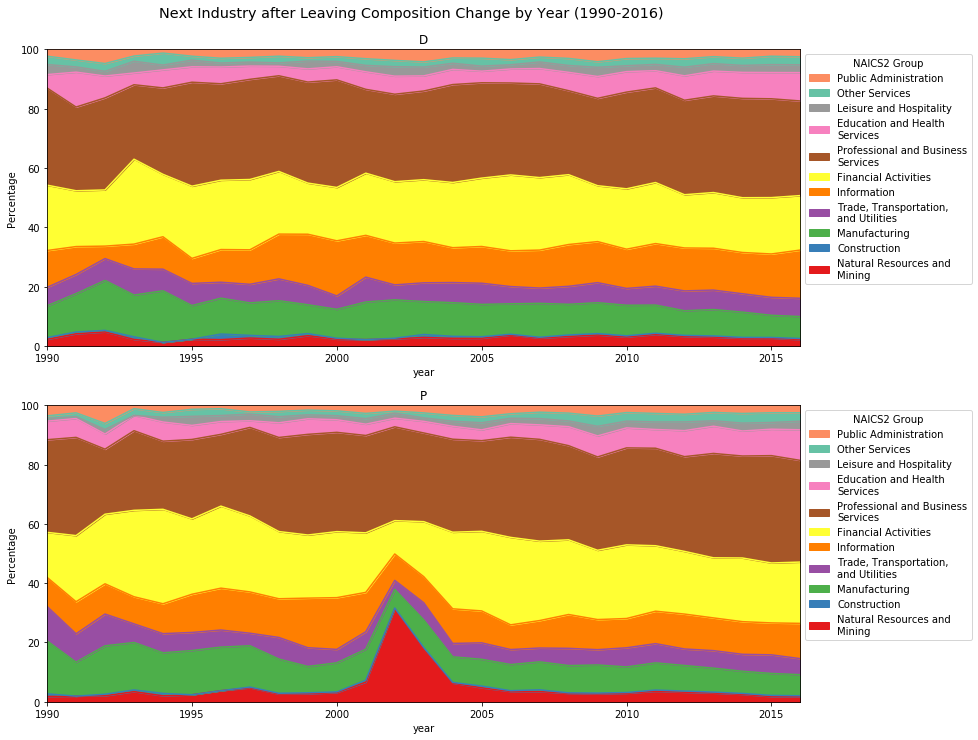

In [27]:
ind_next_lst = sorted(list(set(NAICS2GRP_dict.values())))
colormap_unif = {idx:clr for idx, clr in zip(
    ind_next_lst[:-1], # Assume the last element is "Others".
    itertools.cycle(plt.get_cmap('Set1').colors+plt.get_cmap('Set2').colors+plt.get_cmap('Set3').colors)
)}
colormap_unif[ind_next_lst[-1]] = plt.get_cmap('Dark2').colors[0]

# Codes for showing pie charts:
# fig,axs=plt.subplots(1,2,figsize=(15,7.5))
# for (idx,col),ax in zip(empl_changes_df.loc[lambda df:df.type=='leaving'].pivot_table(
#     index=empl_changes_df.ind_next.apply(lambda x:NAICS2GRP_dict[x[:2]]),
#     columns='ticker', values='gender', aggfunc='count'
# ).iteritems(),axs):
#     col.plot.pie(
#         ax=ax, labeldistance=1.05, title=str(idx).replace("'",''), autopct='%.2f', pctdistance=0.9,
#         colors=[colormap_unif[idx] for idx in col.index], labels=[x[1] for x in col.index]
#     )
#     ax.set_ylabel('')
# plt.show()

## Continued ##
f_none_hidden = True # Whether to show the "None/Unknown"s.

# Plot composition changes by years.
fig, axs = plt.subplots(2,1,figsize=(13.5,12))
fig.suptitle("Next Industry after Leaving Composition Change by Year (1990-2016)", fontsize='x-large', y=0.93)
for (idx, grp), ax in zip(
    empl_changes_df.loc[
        lambda df:(df.year>=1990)&(df.year<=2016)&(df.type=='leaving'), ['ticker','type','year','ind_next']
    ].groupby('ticker'), axs
):
    to_plot = grp.assign(count=1).pivot_table(
        columns=grp.ind_next.apply(lambda x:NAICS2GRP_dict[x[:2]]),
        index='year', values='count', aggfunc='sum', fill_value=0
    )
    if f_none_hidden:
        to_plot.drop(ind_next_lst[-1], axis=1, inplace=True)
    to_plot = to_plot.apply(lambda x:x/sum(x)*100, axis=1)
    to_plot.plot(
        kind='area', ax=ax, color=[colormap_unif[idx] for idx in to_plot.columns],
        ylim=(0,100), title=idx
    )
    ax.set_ylabel("Percentage")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        reversed(handles), ["\n".join(wrap(re.match(r"\(\d+, (.+)\)",x).group(1),25)) for x in reversed(labels)], 
        loc='upper left', bbox_to_anchor=(1,1), title="NAICS2 Group"
    )
plt.show()

## Tenure and Number of Promotions.

Note:
- Tenure = End date of last entry - Start date of first entry in a consecutive sequence of entries in the same company;
 - When there is any invalid month in the two dates and their years are _not_ the same, the invalid month is replaced by 6;
 - When there is any invalid month in the two dates and their years are the same, the invalid month is assumed to be the extreme value (0 for start and 12 for end) and the results are the minimum of their difference and 6.
- Number of promotions = Number of entries in a consecutive sequence of entries in the same company - 1.

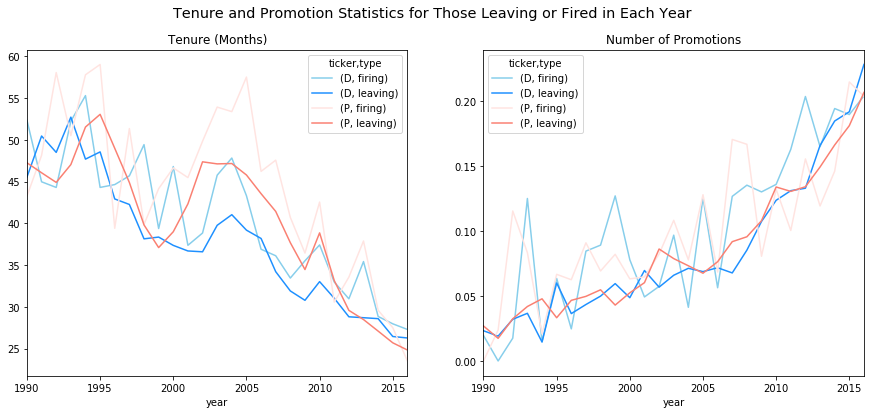

In [28]:
# Calculate.
to_plot = empl_changes_df.loc[lambda df:(df.type!='hiring')&(df.year>=1990)&(df.year<=2016)].astype(
    {'tenure':'Int64','nprom':'Int64'}
).pivot_table(
    columns=['ticker','type'],index='year',values=['tenure','nprom'],aggfunc=np.nanmean
)

# Plot.
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,6))
fig.suptitle("Tenure and Promotion Statistics for Those Leaving or Fired in Each Year",fontsize='x-large')
to_plot['tenure'].plot(
    title="Tenure (Months)", color=[color_styles[0],color_styles[2],color_styles[3],color_styles[5]],ax=ax1
)
to_plot['nprom'].plot(
    title="Number of Promotions", color=[color_styles[0],color_styles[2],color_styles[3],color_styles[5]],ax=ax2
)
plt.show()